# GNN Training

## Imports

In [1]:
import os

import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
from torch.utils.data.sampler import SequentialSampler
from torch_geometric.data import DataLoader

from pg_networks.dynamic_edge import DynamicEdge
from pg_networks.gcn import GCN
from pg_networks.sg import SG
import src.config as cfg
from src.davis_2016 import DAVIS2016
from src.solver import Solver
from src.vis_utils import plot_img_with_contour_and_translation, plot_translations, plot_loss, \
                          plot_combo_img

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Train and Val Dataset

In [2]:
train = DAVIS2016(cfg.PYTORCH_GEOMETRIC_DAVIS_2016_DATASET_PATH,
                  cfg.ANNOTATIONS_AUGMENTED_FOLDERS_PATH, cfg.CONTOURS_FOLDERS_PATH, 
                  cfg.IMAGES_AUGMENTED_FOLDERS_PATH, cfg.TRANSLATIONS_FOLDERS_PATH,
                  cfg.PARENT_MODEL_PATH,
                  cfg.LAYER, cfg.K, cfg.AUGMENTATION_COUNT,
                  cfg.SKIP_SEQUENCES, cfg.TRAIN_SEQUENCES[:cfg.NUM_SEQUENCES], cfg.VAL_SEQUENCES[:cfg.NUM_SEQUENCES],
                  train=True)

In [3]:
val = DAVIS2016(cfg.PYTORCH_GEOMETRIC_DAVIS_2016_DATASET_PATH,
                cfg.ANNOTATIONS_AUGMENTED_FOLDERS_PATH, cfg.CONTOURS_FOLDERS_PATH, 
                cfg.IMAGES_AUGMENTED_FOLDERS_PATH, cfg.TRANSLATIONS_FOLDERS_PATH,
                cfg.PARENT_MODEL_PATH,
                cfg.LAYER, cfg.K, 0,
                cfg.SKIP_SEQUENCES, cfg.TRAIN_SEQUENCES[:5], cfg.VAL_SEQUENCES[:5],
                train=False)

In [4]:
print("Train size: %i" % len(train))
print("Val size: %i" % len(val))

Train size: 6359
Val size: 374


## Visualize some samples

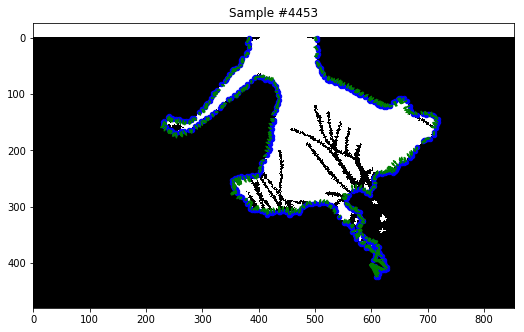

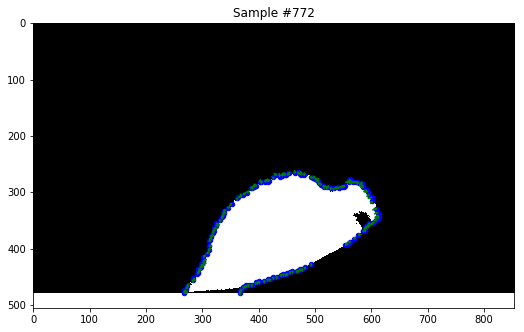

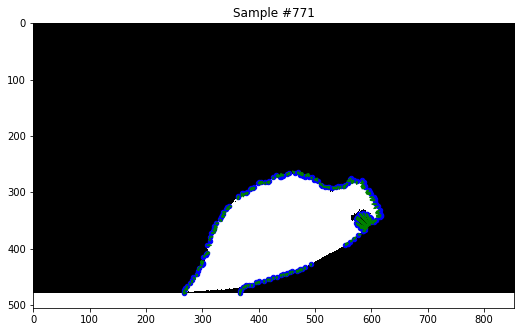

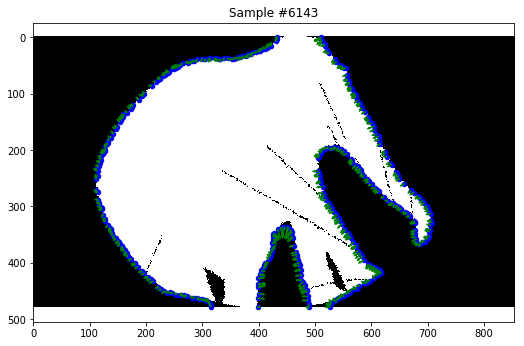

<Figure size 3600x720 with 0 Axes>

In [ ]:
num_to_display = 5

for i in range(num_to_display):
    
    fig = plt.figure(figsize=(num_to_display*10,10))
    
    # randomly select a sample
    rand_i = np.random.randint(0, len(train))
    data = train[rand_i]
    
    # Load corresponding image
    processed_file_name = train.processed_file_names[rand_i]
    folder = processed_file_name[:-11]
    augmentation_count = processed_file_name[-10:-9]
    file_name = processed_file_name[-8:-3]
    
    image_path = os.path.join(val.raw_paths[0], folder, augmentation_count,
                                ('{}{}'.format(file_name, '.png')))
    if not os.path.exists(image_path):
        continue
    
    image = imageio.imread(image_path)
    
    ax = plt.subplot(1, num_to_display, i + 1)
    ax.set_title('Sample #{}'.format(rand_i))
    
    plot_img_with_contour_and_translation(image, data.contour, data.y)

## Simple GCN

In [ ]:
data = train[0]

model = GCN(in_channels=data.num_features, 
            out_channels=data.y.shape[1])

print(model)

GCN(
  (conv1): GCNConv(128, 256)
  (conv2): GCNConv(256, 256)
  (conv3): GCNConv(256, 512)
  (conv4): GCNConv(512, 512)
  (lin1): Linear(in_features=512, out_features=256, bias=True)
  (lin2): Linear(in_features=256, out_features=128, bias=True)
  (lin3): Linear(in_features=128, out_features=2, bias=True)
)


## Overfit

In [ ]:
num_train = 80
num_val = 20

overfit_train_loader = DataLoader(train, batch_size=16, 
                                  shuffle=False, sampler=SequentialSampler(range(num_train)))
overfit_val_loader = DataLoader(train, batch_size=1, 
                                shuffle=False, sampler=SequentialSampler(range(num_val)))

# Load model and run the solver
overfit_model = GCN(in_channels=data.num_features, 
                    out_channels=data.y.shape[1])

overfit_solver = Solver(optim_args={"lr": cfg.LEARNING_RATE})
overfit_solver.train(overfit_model, overfit_train_loader, overfit_val_loader,
                     num_epochs=5, log_nth=100, verbose=True)

START TRAIN.


/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[Epoch 1/5] train_loss: 12.95340 - val_loss: 4.22010
[Epoch 2/5] train_loss: 3.36919 - val_loss: 4.10596
[Epoch 3/5] train_loss: 3.25683 - val_loss: 4.13742
[Epoch 4/5] train_loss: 3.21973 - val_loss: 4.19290
[Epoch 5/5] train_loss: 3.19333 - val_loss: 4.23266
FINISH.


## Train

In [ ]:
train_loader = DataLoader(train, batch_size=cfg.BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val, batch_size=cfg.BATCH_SIZE, shuffle=False)

# Load model and run the solver
model = GCN(in_channels=train[0].num_features, 
            out_channels=train[0].y.shape[1])

solver = Solver(optim_args={"lr": cfg.LEARNING_RATE,
                            "weight_decay": cfg.WEIGHT_DECAY})

solver.train(model, train_loader, val_loader,
             num_epochs=cfg.NUM_EPOCHS, log_nth=1000, verbose=True)

START TRAIN.
[Epoch 1/20] train_loss: 111.05438 - val_loss: 45.27770
[Epoch 2/20] train_loss: 107.40869 - val_loss: 45.58719
[Epoch 3/20] train_loss: 106.74184 - val_loss: 45.55156
[Epoch 4/20] train_loss: 106.55254 - val_loss: 46.22032
[Epoch 5/20] train_loss: 105.39511 - val_loss: 46.39406
[Epoch 6/20] train_loss: 104.89153 - val_loss: 46.02745
[Epoch 7/20] train_loss: 103.96946 - val_loss: 46.28090
[Epoch 8/20] train_loss: 103.08872 - val_loss: 46.29444
[Epoch 9/20] train_loss: 102.43861 - val_loss: 46.50649


In [ ]:
plot_loss(solver)

## Visualize outputs (ground truth in green, prediction in red)

In [ ]:
model.cpu()
model.double()
model.eval()
num_to_display = 10

for i in range(num_to_display):

    fig = plt.figure(figsize=(num_to_display*10,10))
    
    # randomly select a sample
    rand_i = np.random.randint(0, len(val))
    data = val[rand_i]
    
    # Load corresponding image
    processed_file_name = val.processed_file_names[rand_i]
    folder = processed_file_name[:-11]
    augmentation_count = processed_file_name[-10:-9]
    file_name = processed_file_name[-8:-3]
    
    image_path = os.path.join(val.raw_paths[0], folder, augmentation_count,
                                ('{}{}'.format(file_name, '.png')))
    
    image = imageio.imread(image_path)
    
    with torch.no_grad():
        translation_pred = model(data)
    
    ax = plt.subplot(1, num_to_display, i + 1)
    ax.set_title('Sample #{}'.format(rand_i))
    
    plot_translations(image, data.contour, data.y, translation_pred) 

## Hyperparameter Tuning

In [ ]:
train_loader = DataLoader(train, batch_size=cfg.BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val, batch_size=cfg.BATCH_SIZE, shuffle=False)

learning_rates = [1e-2, 1e-4, 1e-6]
weight_decays = [1e-0, 1e-2, 1e-4]

best_model = None
best_loss = 1e10

i = 0
for learning_rate in learning_rates:
    if i == 0: break
    for weight_decay in weight_decays:
        model = GCN(in_channels=train[0].num_features, 
                    out_channels=train[0].y.shape[1])
        solver = Solver(optim_args={"lr": LEARNING_RATE,
                            "weight_decay": WEIGHT_DECAY})
        solver.train(model, train_loader, val_loader,
             num_epochs=20, log_nth=100, verbose=False)

        # Predict on the validation set
        val_loss = max(solver.val_loss_history)
        print('Hyperparamter Tuning #', i + 1,
                'lr: ', learning_rate,
                'wd: ', weight_decay,
                'val_loss: ', val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model

        i += 1